# Physics 305 Demo Notebook 2: Calculating the Displacement Probability Distribution (PDF) from a Time-Series - Brownian Motion

The probability density function (PDF) for the displacement $\Delta x = x_1 - x_0$ has the form (Eq. 1):

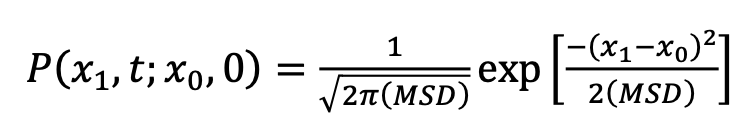

For Brownian motion, MSD $= 2Dt$, where $D$ is the diffusion coefficient.In this case, the PDF is a Gaussian with a standard deviation of $\sqrt{2Dt}$ (as derived in class).

For any two points $x_i$ and $x_j$, we define the lag time $\tau$ to be $t_j - t_i$. Then, the PDF for a given lag time $\tau$ is given by Eq. (1) with MSD $= 2D\tau$.

Here, we will generate the PDF of displacements for different lag times for standard Brownian motion samples and compare them with the analytical result from Eq. (1). Recall that for standard Brownian motion, $D=1/2$.


### Step 1: Generate Brownian motion samples

In [1]:
# import libraries
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set random seed
np.random.seed(seed=17)

# Set parameters
n_samp = 5 # no. of samples/realizations
n = int(1e6)  # no. of timesteps
dt = 1.  # size of time step
sd = np.sqrt(dt) # standard deviation
t = dt*np.arange(n) # time

# Initialize array to hold the BM samples
x_samp = np.zeros((n, n_samp))

# Loop over realizations
for i in np.arange(n_samp):
  # Generate random numbers from Gaussian distribution centered at 0 and standard deviation sd
  rnd = norm.rvs(size = n, scale = sd)
  # Get cumulative sum of the elements of the array of random numbers
  x_samp[:, i] = np.cumsum(rnd)

In [3]:
np.shape(x_samp)

(1000000, 5)

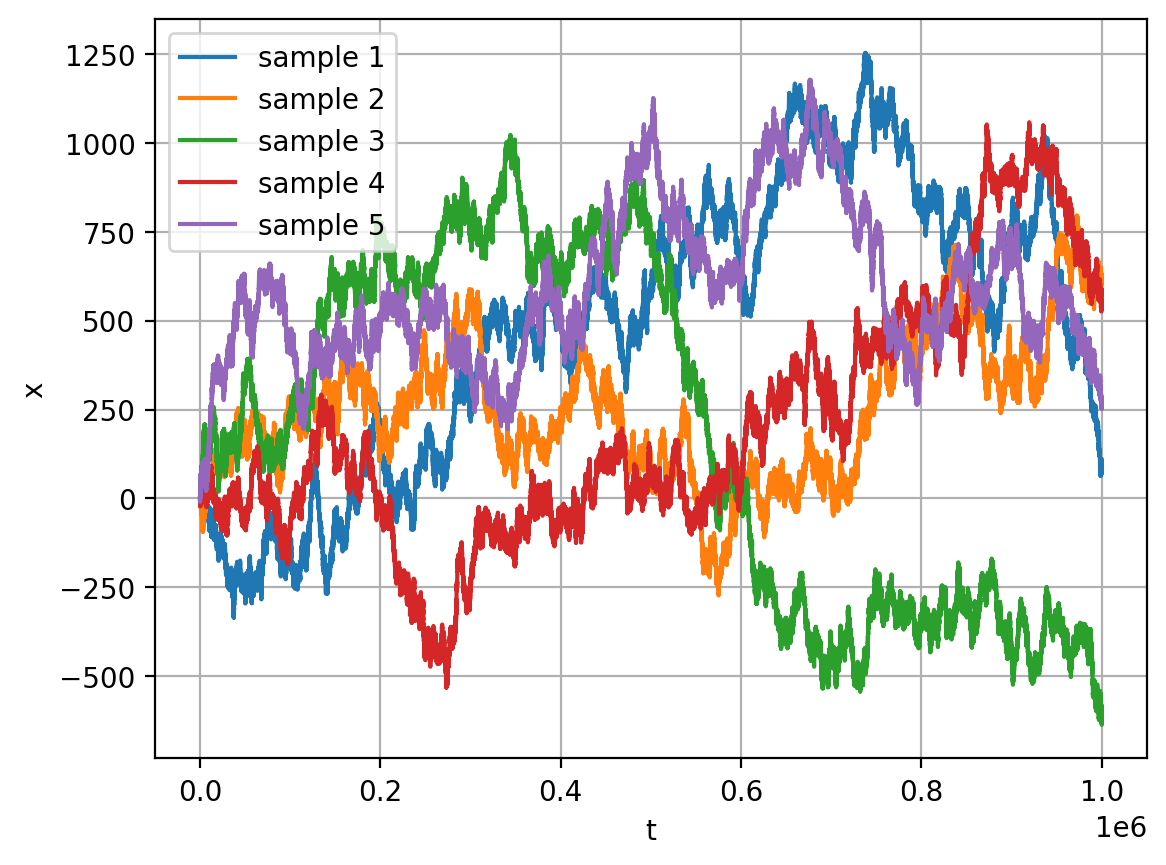

In [7]:
# Plot BM samples
plt.figure(dpi = 200)
plt.grid()
for i in np.arange(n_samp):
  plt.plot(t, x_samp[:, i],label="sample %d" % (i+1), marker = ',', ls = '-')
plt.xlabel("t")
plt.ylabel("x")
plt.legend(loc="upper left")

### Step 2: Generate PDF for a specific lag time

For lag time $\tau = 100$ ($\Delta$ = 100 time steps), there are $n_{\rm pair} = n-\Delta = 10^6-100 = 999,900$ pairs of data points we can get the displacement $\Delta x$ for.

In [8]:
tau = 100
delta = int(np.round(tau/dt))

print("tau: %d, Delta: %d" % (tau, delta))

tau: 100, Delta: 100


For simplicity of the code, let us calculate the PDF for a specific BM sample (the first one):

In [9]:
x = x_samp[:, 0]

We want to get the displacement values $\Delta x$ for each pair of data points. To leverage vectorization in numpy, we define a truncated and shifted copy of the original $x$ array and subtract the two.

In [10]:
# get truncated copy of x, ending in initial data point of the last pair
x_trunc = x[:-1*delta]

# get shifted copy of x, starting from end data point of the first pair
x_shift = x[delta:]

# get displacements
dx = x_shift - x_trunc

In [11]:
len(dx), len(x_trunc), len(x_shift)

(999900, 999900, 999900)

Next, we plot the PDF of the displacements $\Delta x$ and overlay the analytical result from Eq. (1)-- a Gaussian distribution with standard deviation equal to ${\rm MSD}^{1/2} = \sqrt{2D\tau} = \sqrt{2*0.5*\tau} = \sqrt{\tau} = \sqrt{100} = 10$ (since $D=1/2$ for our standard Brownian motion sample).

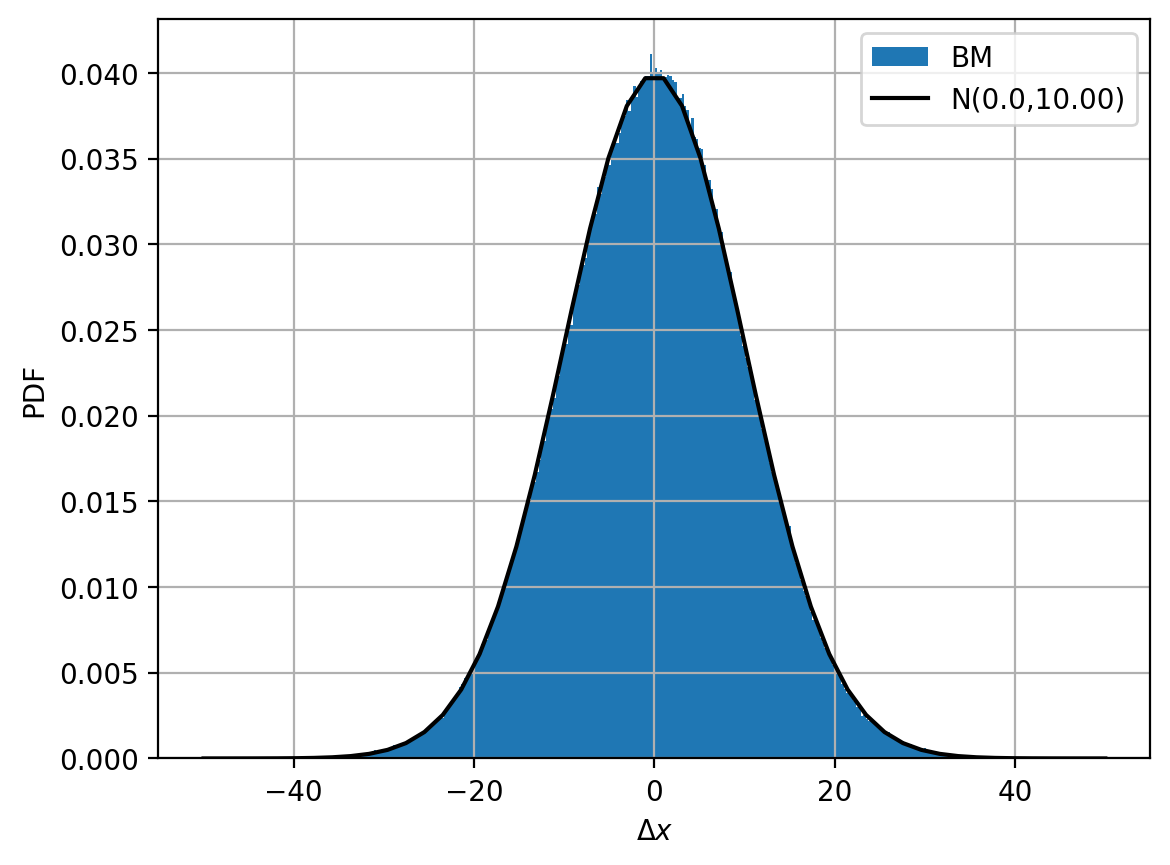

In [12]:
# Generate normal distribution
xx_sd = np.sqrt(tau)
xx = np.linspace(-5, 5)*xx_sd # gridded points from -5 to 5 in units of sd
xx_mean = 0.
yy = norm.pdf(xx, xx_mean, xx_sd)

plt.figure(dpi = 200)
plt.grid()
# Plot PDF of displacements
plt.hist(dx, density=True, bins="auto", label="BM")
plt.xlabel("Delta x")
plt.ylabel("PDF")

# Overlay normal distribution
plt.plot(xx, yy, 'k-', label="N(%.1f,%.2f)" % (xx_mean, xx_sd))
plt.ylabel("PDF")
plt.xlabel(r"$\Delta x$")
plt.legend(loc="best")

### Step 3: Generate PDF for different lag times

We calculate the PDF for these lag times $\tau = 10, 10^2, 10^3, 10^4, 10^5, 9 \times 10^5$. Note that for the last value, there are only $10^6 - 9 \times 10^5 = 10^5$ pairs of data points to get displacements from.

Here, we also perform the calculations for all BM samples and store the results in the same output array.

In [13]:
tau_vals = np.array([10, 1e2, 1e3, 1e4, 1e5, 9e5])
delta_vals = np.round(tau_vals/dt).astype(int)
n_tau = len(tau_vals)

# initialize array to store displacements
# note that the size n is larger than the actual number of values to be stored
# values are initialized to NaN (which are not included in the PDF calculation)
dx_tau = np.empty((n, n_tau, n_samp))*np.nan

for i_samp in np.arange(n_samp):
  for i, tau in enumerate(tau_vals):
    delta = delta_vals[i]

    # get truncated copy of x, ending in initial data point of the last pair
    x_trunc = x_samp[:-1*delta, i_samp]

    # get shifted copy of x, starting from end data point of the first pair
    x_shift = x_samp[delta:, i_samp]

    # get displacements
    dx = x_shift - x_trunc

    # store in output array
    dx_tau[:len(dx), i, i_samp] = dx

    #print(i, tau, delta, len(dx))

Apply sanity check: check length of non-NaN values with expected counts

In [14]:
for i in np.arange(n_tau):
  n_dx = len(dx_tau[np.isnan(dx_tau[:,i,0])==False,i,0])
  print(n_dx, n-delta_vals[i])

999990 999990
999900 999900
999000 999000
990000 990000
900000 900000
100000 100000


Finally, let us plot the PDFs with the analytical results overlaid.

Recall that MSD $= \tau$ for the case of standard Brownian motion and that the expected PDF is a Gaussian with a standard deviation of MSD$^{1/2}$.

In [16]:
# define plotting function
def plot_pdf_bm(dx, tau):

  # Generate normal distribution
  xx_mean = 0.
  xx_sd = np.sqrt(tau)
  xx = np.linspace(-5, 5)*xx_sd # gridded points from -5 to 5 in units of sd
  yy = norm.pdf(xx, xx_mean, xx_sd)

  # Plot PDF of displacements
  plt.hist(dx, density=True, bins="auto", label="BM", alpha=0.4)
  plt.xlabel("Delta x")
  plt.ylabel("PDF")

  # Overlay normal distribution
  plt.plot(xx, yy, 'k-', label="N(%.1f,%.2f)" % (xx_mean, xx_sd))
  plt.ylabel("PDF")
  plt.xlabel(r"$\Delta x$")
  #plt.legend(loc="best")
  plt.title(r"$\tau$ = %.0e, sd = %.2f" % (tau, xx_sd))

<ipython-input-17-8724058e6cf6>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


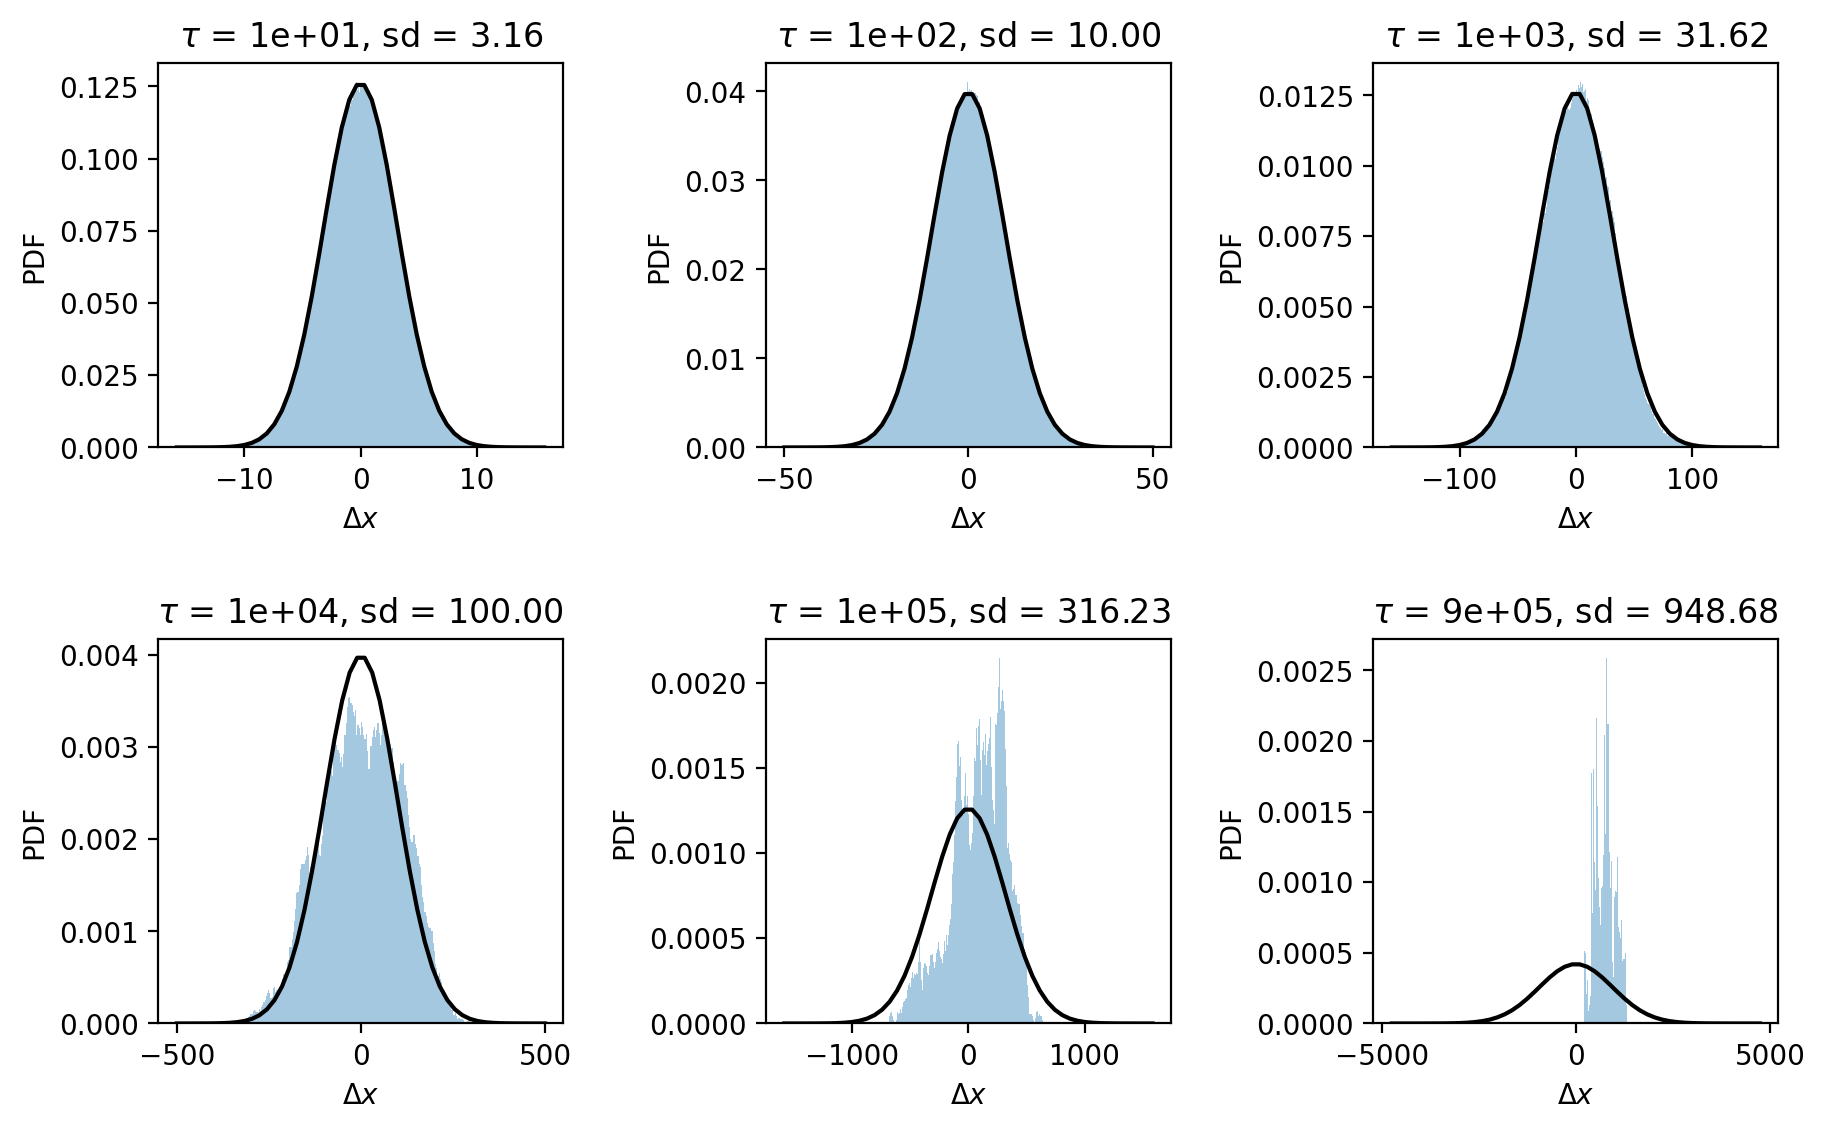

In [17]:
# generate plot for 1 sample
i_samp = 0 # select sample to plot (by index)


plt.figure(figsize=(12,6), dpi = 200)
plt.grid()
for i in np.arange(n_tau):
  plt.subplot(2,3,i+1)
  plot_pdf_bm(dx_tau[:,i,i_samp], tau_vals[i])

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)

<ipython-input-18-0eefabcb765c>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,i+1)


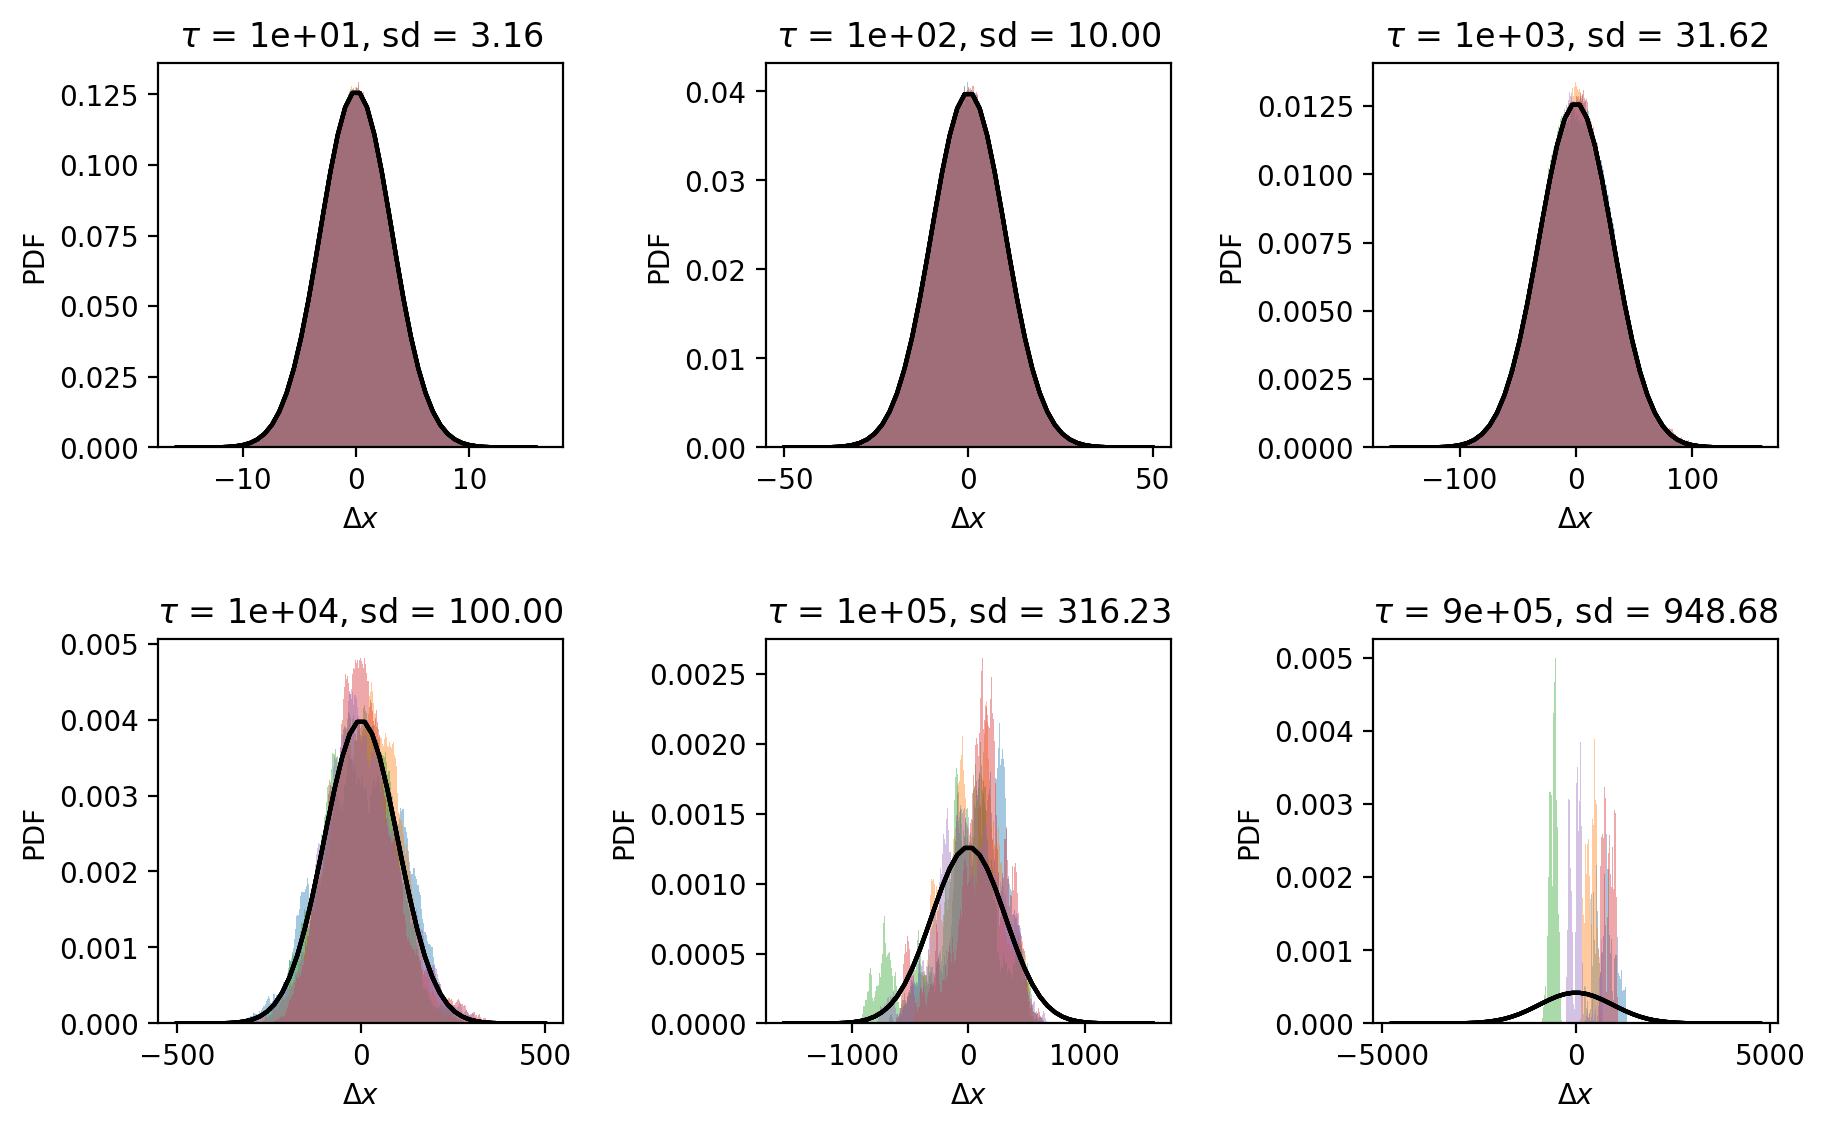

In [18]:
# generate plot showing PDF of all samples

plt.figure(figsize=(12,6), dpi = 200)
plt.grid()
for i in np.arange(n_tau):
  plt.subplot(2,3,i+1)
  for i_samp in np.arange(n_samp):
    plot_pdf_bm(dx_tau[:,i,i_samp], tau_vals[i])

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, hspace=0.5, wspace=0.5)

We see that for large lag times, the small number statistics (lower numbers of data point pairs) result in narrower PDFs than the analytical result. The PDFs of individual samples may also be biased to the left or right, but taken together the different samples "balance out".

This result indicates that there is an upper limit to the lag time that we can constrain the PDF for, depending on the size of the dataset.